# CVAE using embeddings as conditional variables

In the publication 
[Population-level integration of single-cell datasets enables multi-scale analysis across samples](https://doi.org/10.1038/s41592-023-02035-2)
the authors propose a CVAE model that uses [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
as conditional variables. 
These embeddings are also trained.
To add a new condition to the model, all weights are frozen and just new conditions are trained.
This enables to integrate new conditions to the trained model and without retraining of all weights. 

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import lightning.pytorch as pl

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

from utils import plot_latent, plot_reconstructed_ecvae

%load_ext autoreload
%autoreload 2

In [2]:
ds = torchvision.datasets.MNIST('/scratch/trose/mnist',
                                transform=torchvision.transforms.ToTensor(),
                                download=True)

In [3]:
device = "cuda" # Use "cpu" if no GPU is available.
# Creating a dataloader
data = torch.utils.data.DataLoader(
        ds,
        batch_size=128,
        shuffle=True)

## Model

The new model will be based on the model from the previous notebook

In [4]:
from utils import CondVariationalAutoencoder

class eCVAEModel(pl.LightningModule):
    # Here we need to define the number of classes and embedding dimensions
    def __init__(self, latent_dims, n_classes, embedding_dims):
        super().__init__()
        # We can use the CVAE model from the previous notebook, but instead of using the number of classes for a one-hot encoding,
        # we use the embedding dimensions
        self.cvae = CondVariationalAutoencoder(latent_dims, embedding_dims)
        self.n_classes = n_classes
        self.embedding_dims = embedding_dims
        self.embed_cond = nn.Embedding(num_embeddings=n_classes, embedding_dim=embedding_dims, max_norm=True)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Instead of a one-hot encoding, the embeddings are used as conditional variables
        x_hat = self.cvae(x, self.embed_cond(y))
        loss = loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl
        
        self.log('Training loss', loss, on_step=False, on_epoch=True, logger=False, prog_bar=True)
        
        return loss
    
    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)


In [17]:
latent_dims=2

In [13]:
# Training of the model

model = eCVAEModel(latent_dims=latent_dims, n_classes=10, embedding_dims=5)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Missing logger folder: /home/trose/lightning-cvae/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoenco

Epoch 19: 100%|██████████| 469/469 [00:09<00:00, 48.50it/s, v_num=0, Training loss=4.27e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:09<00:00, 48.31it/s, v_num=0, Training loss=4.27e+3]


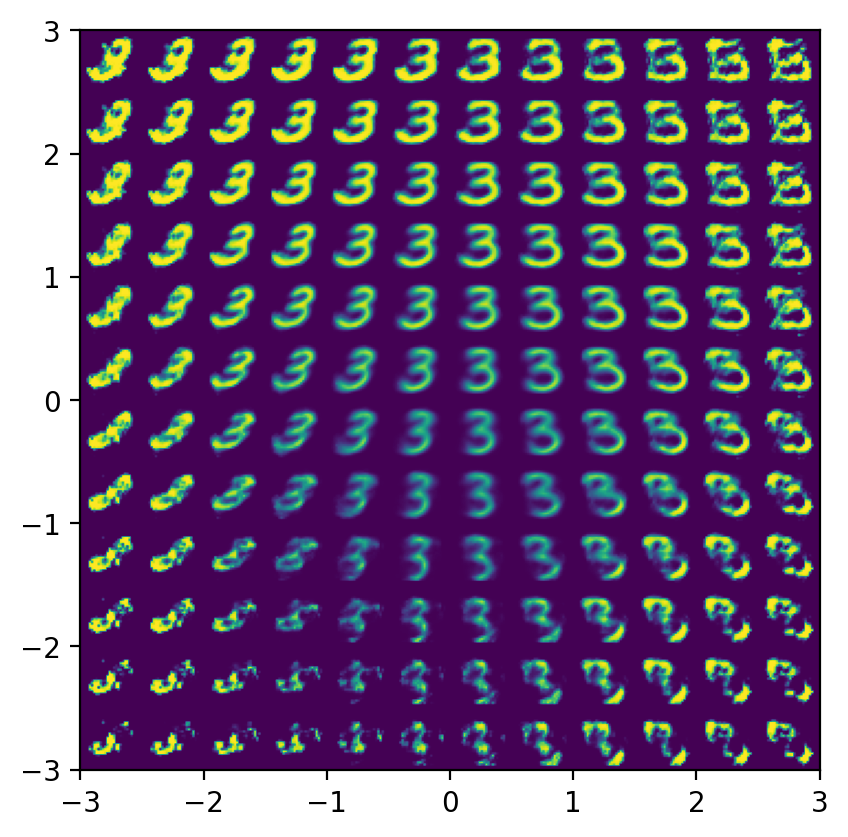

In [31]:
# Lightning is sending the model to the cpu after training, therefore we need to send it back to the gpu
model.to('cuda')

# Visualization of the latent space as shown previously after training
# This is a slightly modified function compared to the previous notebook, check the `utils.py` file.
plot_reconstructed_ecvae(model, r0=(-3, 3), r1=(-3, 3), number=3, device='cuda')

## Integration of new conditions

In the next step, we will train the model on a subset of conditions, then freeze the model weights and train new embeddings for previously excluded conditions.

In [10]:
# Creating dataloaders excluding 8 & 9 digits
# Code adapted from: https://stackoverflow.com/questions/75034387/remove-digit-from-mnist-pytorch
dstrain = torchvision.datasets.MNIST('/scratch/trose/mnist',
                                transform=torchvision.transforms.ToTensor(),
                                download=True)
idxn9 = dstrain.targets!=9
idxn8 = dstrain.targets!=8

idx = idxn9 & idxn8

dstrain.targets = dstrain.targets[idx]
dstrain.data = dstrain.data[idx]

# Data containing only 8 & 9 digits
ds89 = torchvision.datasets.MNIST('/scratch/trose/mnist',
                                transform=torchvision.transforms.ToTensor(),
                                download=True)
idx9 = ds89.targets==9
idx8 = ds89.targets==8

idx89 = idx9 | idx8

ds89.targets = ds89.targets[idx89]
ds89.data = ds89.data[idx89]

In [16]:
datatrain = torch.utils.data.DataLoader(dstrain, batch_size=128, shuffle=True)
data89 = torch.utils.data.DataLoader(ds89, batch_size=128, shuffle=True)

In [18]:
# Training of the model
latent_dims=2
model = eCVAEModel(latent_dims=latent_dims, n_classes=10, embedding_dims=5)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(model, datatrain)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K 
1 | embed_cond | Embedding                  | 50    

Epoch 19: 100%|██████████| 377/377 [00:07<00:00, 51.81it/s, v_num=1, Training loss=4.35e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 377/377 [00:07<00:00, 51.55it/s, v_num=1, Training loss=4.35e+3]


In [31]:
# Check if the model parameters are actually frozen
tmp = list(model.named_parameters())[0][1].detach().numpy()

In [36]:
# Freeze model parameters
for name, param in model.named_parameters():
    if name == 'embed_cond.weight':
        param.requires_grad = True
    else:
        param.requires_grad = False

# Training just on 8 & 9 digits on frozen weights
# The model is using the previously created embedding vectors in the model that were not updated for 8 & 9 in the previous training.
trainer89 = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer89.fit(model, data89)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | cvae       | CondVariationalAutoencoder | 812 K 
1 | embed_cond | Embedding                  | 50    
----------------------------------------------------------
50        Trainable params
812 K     Non-trainable params
812 K     Total params
3.251     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 93/93 [00:01<00:00, 55.04it/s, v_num=3, Training loss=5.62e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 93/93 [00:01<00:00, 54.42it/s, v_num=3, Training loss=5.62e+3]


In [40]:
# Check if model weights were not changed
(list(model.named_parameters())[0][1].detach().numpy() == tmp).all()

True

### Visualization of inference

We can see below that the model is able to generate images similar to 8 & 9s, but in a much worse quality compared to the digits generated on the full training data.

However the big advantage is that we were able to add new conditions without retraining the model.

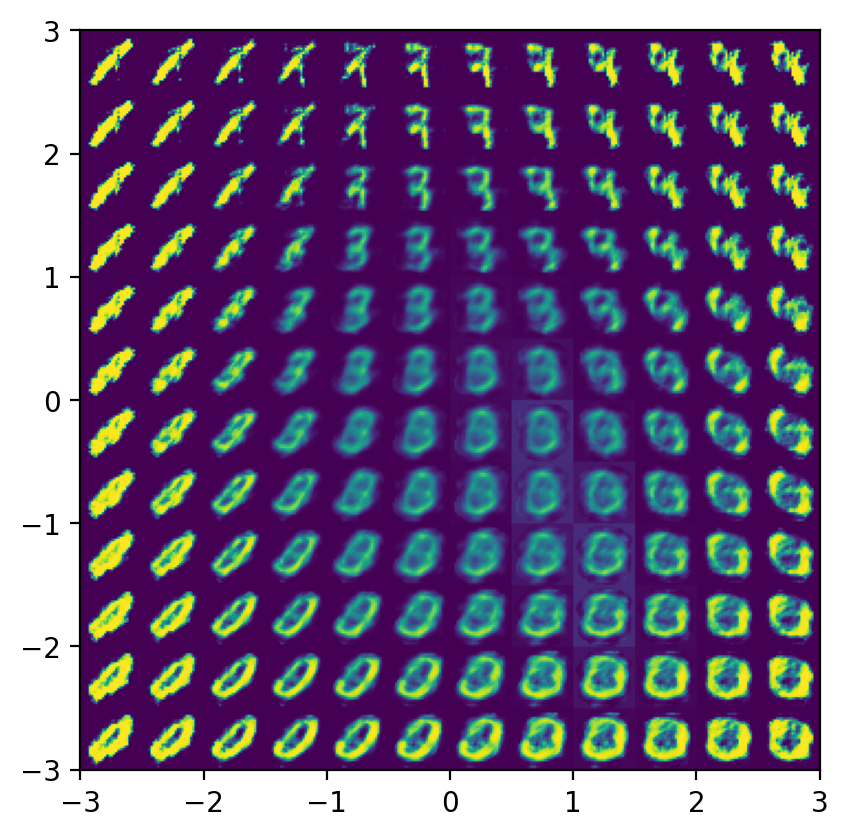

In [43]:
model.to('cuda')

# Visualization of the latent space as shown previously after training
# This is a slightly modified function compared to the previous notebook, check the `utils.py` file.
plot_reconstructed_ecvae(model, r0=(-3, 3), r1=(-3, 3), number=8, device='cuda')

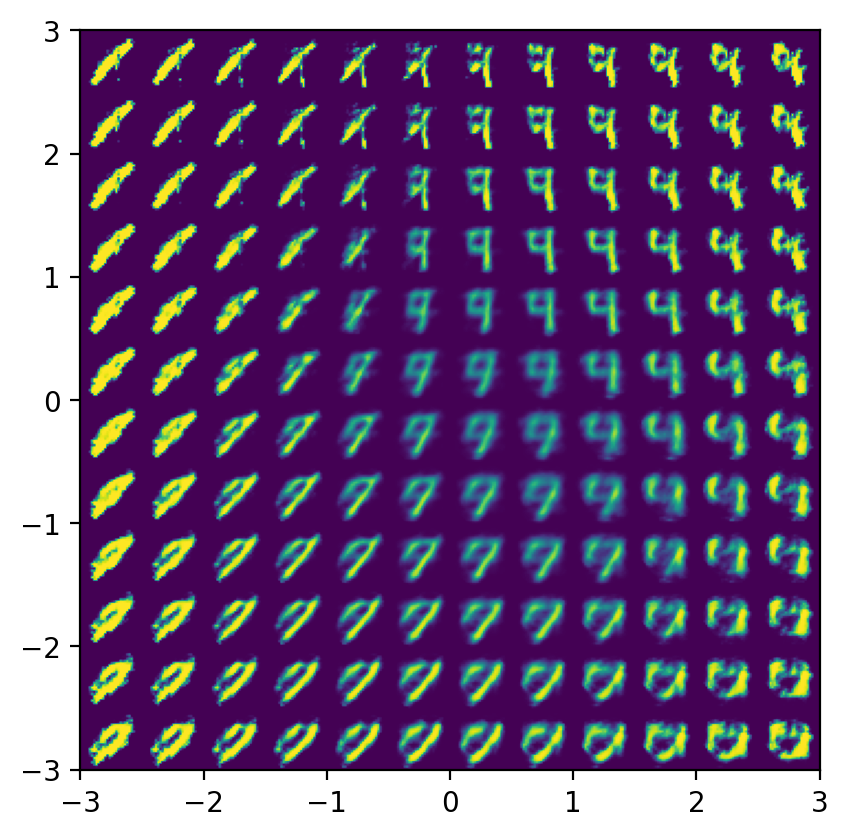

In [42]:
model.to('cuda')

# Visualization of the latent space as shown previously after training
# This is a slightly modified function compared to the previous notebook, check the `utils.py` file.
plot_reconstructed_ecvae(model, r0=(-3, 3), r1=(-3, 3), number=9, device='cuda')